In [1]:
import os
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from openpyxl.utils import get_column_letter
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary
# NUEVO 
import torch.nn.functional as F

In [6]:
ruta_carpeta = "/Users/Usuario/OneDrive/Escritorio/tfg/probeta 1/"
num_ensayos=11
nombres_archivos = [f"ENSAYO_{i}.xlsx" for i in range(num_ensayos)]

# Intervalo de frecuencias de cada canal
intervalo_canales = [
    (4, 804),      
    (810, 1610),   
    (1616, 2416),
    (2422, 3222),
    #(3228, 4028), Nos saltamos el sensor 5
    (4034, 4834),
    (4840, 5640),
    (5646, 6446),
    (6452, 7252),
    (7258, 8058)
]
# Definir las columnas de frecuencia, parte real y parte imaginaria para cada rango
frecuencia_col = [1, 4, 7, 10, 13, 16, 19, 22, 25]  # A, D, J
real_col = [2, 5, 8, 11, 14, 17, 20, 23, 26]  # B, E, K
imagin_col = [3, 6, 9, 12, 15, 18, 21, 24, 27]  # C, F, L
# Convertimos estas a letras para el print
frecuencia_col_letras = [get_column_letter(col) for col in frecuencia_col]
real_col_letras = [get_column_letter(col) for col in real_col]
imagin_col_letras = [get_column_letter(col) for col in imagin_col]

In [7]:
# Obtenemos las partes reales e imagin separadas por ensayo, hojas, canales y rangos
data_frecuencias = []
data_partes_reales = []
data_partes_imagin = []
for ensayo_idx, nombre_archivo in enumerate(nombres_archivos):
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    wb = openpyxl.load_workbook(ruta_archivo)

    sweep1=wb['Sweep_1']
    sweep2=wb['Sweep_2']
    sweep3=wb['Sweep_3']
    
    sweeps = [sweep1, sweep2, sweep3]
    
    if ensayo_idx == 0:  # Solo se almacena una vez porque las frecuencias no cambian entre ensayos
        for col in frecuencia_col:
            column_data = [sweeps[0].cell(row=i, column=col).value for i in range(4, 805)]
            data_frecuencias.append(column_data)

    ensayo_partes_reales = []
    ensayo_partes_imagin = []
    
    for sheet in sweeps:
        sweep_data_reales = []
        sweep_data_imagin = []
        for inicio, fin in intervalo_canales:
            canal_data_reales = []
            canal_data_imagin = []
            for col_r, col_i in zip(real_col, imagin_col):
                column_data_reales = [sheet.cell(row=i, column=col_r).value for i in range(inicio, fin + 1)]
                column_data_imagin = [sheet.cell(row=i, column=col_i).value for i in range(inicio, fin + 1)]
                canal_data_reales.append(column_data_reales)
                canal_data_imagin.append(column_data_imagin)
            sweep_data_reales.append(canal_data_reales)
            sweep_data_imagin.append(canal_data_imagin)
        ensayo_partes_reales.append(sweep_data_reales)
        ensayo_partes_imagin.append(sweep_data_imagin)
    data_partes_reales.append(ensayo_partes_reales)
    data_partes_imagin.append(ensayo_partes_imagin)

In [7]:
# Ahora, imprimir las partes reales y las imaginarias para comprobar la estructura
# print("\nPartes Reales y Partes Imaginarias:")

# Recorremos los datos de partes reales e imaginarias
# for ensayo_idx, (sweep_reales, sweep_imagin) in enumerate(zip(data_partes_reales, data_partes_imagin), start=1):
#     print(f"\nEnsayo {ensayo_idx-1}:")
#     for sweep_idx, (sweep_data_reales, sweep_data_imagin) in enumerate(zip(sweep_reales, sweep_imagin), start=1):
#         print(f"  Barrido {sweep_idx}:")
        
#         for canal_idx, (canal_reales, canal_imagin) in enumerate(zip(sweep_data_reales, sweep_data_imagin), start=1):
#             print(f"    Canal {canal_idx}:")
#             for col_idx, (column_reales, column_imagin) in enumerate(zip(canal_reales, canal_imagin), start=1):
#                 print(f"      Columna {real_col_letras[col_idx-1]}:")
#                 print(f"        Parte Real (primeros 5 valores): {column_reales[:5]}")
#                 print(f"        Parte Imaginaria (primeros 5 valores): {column_imagin[:5]}")


In [16]:
data_frecuencias_np = np.array(data_frecuencias)
data_partes_reales_np = np.array(data_partes_reales)
data_partes_imagin_np = np.array(data_partes_imagin)

In [17]:
print(data_frecuencias_np.shape)
print(data_partes_reales_np.shape)
print(data_partes_imagin_np.shape)

(9, 801)
(11, 3, 9, 9, 801)
(11, 3, 9, 9, 801)


In [18]:
data_partes_reales_np_reshaped=data_partes_reales_np.reshape(11, 3, 9, 81, 89)
data_partes_reales_np_reshaped.shape

(11, 3, 9, 81, 89)

In [19]:
data_partes_imagin_np_reshaped=data_partes_imagin_np.reshape(11, 3, 9, 81, 89)
data_partes_imagin_np_reshaped.shape

(11, 3, 9, 81, 89)

In [13]:
# #VISUALIZACIÓN DE SEÑALES: Subplots de las señales separados por sensor, carga y sensor-barrido
# n_ensayos, n_barridos, n_sensores, n_puntos = (11, 3, 9, 7209)
# colormap = plt.get_cmap("tab20")
# # Parte real
# for sensor in range(n_sensores):
#     fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
#     if sensor<4:
#         fig.suptitle(f"Parte Real para Sensor {sensor+1}", fontsize=16)
#     else: fig.suptitle(f"Parte Real para Sensor {sensor+2}", fontsize=16)
    
#     # Iteramos sobre cada barrido
#     for barrido in range(n_barridos):
#         ax = axs[barrido]  
#         for ensayo in range(n_ensayos):
#             color = colormap(ensayo % 20)
#             ax.plot(data_frecuencias_np_reshaped,data_partes_reales_np_reshaped[ensayo, barrido, sensor], label=f"Ensayo {ensayo+1}", color=color)
        
#         ax.set_ylabel(f"Barrido {barrido+1}")
#         ax.legend(fontsize=8, loc="upper right")
    
#     axs[-1].set_xlabel("Frecuencia [Hz]")
#     plt.tight_layout()
#     plt.show()

In [14]:
# #Parte imaginaria
# for sensor in range(n_sensores):
#     fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
#     if sensor<4:
#         fig.suptitle(f"Parte Imaginaria para Sensor {sensor+1}", fontsize=16)
#     else: fig.suptitle(f"Parte Imaginaria para Sensor {sensor+2}", fontsize=16)
    
#     # Iteramos sobre cada barrido
#     for barrido in range(n_barridos):
#         ax = axs[barrido]  
#         for ensayo in range(n_ensayos):
#             color = colormap(ensayo % 20)
#             ax.plot(data_frecuencias_np_reshaped,data_partes_imagin_np_reshaped[ensayo, barrido, sensor, :], label=f"Ensayo {ensayo+1}",color=color)
        
#         ax.set_ylabel(f"Barrido {barrido+1}")
#         ax.legend(fontsize=8, loc="upper right")
    
#     axs[-1].set_xlabel("Frecuencia [Hz]")
#     plt.tight_layout()
#     plt.show()

In [20]:
data_partes_reales_tensor = torch.tensor(data_partes_reales_np_reshaped, dtype=torch.float32)
data_partes_imagin_tensor = torch.tensor(data_partes_imagin_np_reshaped, dtype=torch.float32)
torch.save(data_partes_reales_tensor, 'tensor_emis_real_corto.pt')
torch.save(data_partes_imagin_tensor, 'tensor_emis_imagin_corto.pt')

In [15]:
data_partes_reales_tensor=torch.load('tensor_emis_real_corto.pt')
data_partes_imagin_tensor=torch.load('tensor_emis_imagin_corto.pt')


# Definición del Autoencoder Variacional (VAE)
class FactorVAE(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 3, stride=2, padding=2),
            nn.ReLU()
        )
        
       # Obtener tamaño de salida del encoder dinámicamente
        with torch.no_grad():
            sample_input = torch.randn(1, 1, 89)
            sample_output = self.encoder(sample_input)
            encoded_dim = sample_output.numel() // sample_output.shape[0]
            print(encoded_dim)

        self.fc_mu = nn.Linear(encoded_dim, latent_dim)
        self.fc_logvar = nn.Linear(encoded_dim, latent_dim)
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, encoded_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 64, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 3, stride=2, padding=2),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplanamos
        #print(f"Tamaño después del encoder: {x.shape}")  # Depuración
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        x = self.decoder_fc(z).view(x.size(0), 64, -1)
        x = self.decoder(x)
        return x, mu, logvar

In [16]:
print(data_partes_reales_tensor.shape)
print(data_partes_imagin_tensor.shape)

torch.Size([11, 3, 9, 81, 89])
torch.Size([11, 3, 9, 81, 89])


In [17]:
# Discriminador para la TC

# "Quiero que cada dimensión del código latente (el vector z) represente una cosa distinta e independiente del resto. 
# Por ejemplo, una dimensión para la temperatura, otra para el daño, otra para el material, etc."

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)   # Salida: 2 valores → "es real" o "es barajado"
        )
    
    def forward(self, z):
        return self.model(z)

# Función para permutar las dimensiones del vector latente. Esta fuera de la clase del Discriminador
def permute_dims(z):
# Recibe como entrada el tensor z, que tiene dimensiones [batch_size, latent_dim].
# Ejemplo:
# Si z tiene 64 muestras (batch_size = 64) y 16 dimensiones (latent_dim = 16), su tamaño será [64, 16].
    B, D = z.size() #B: número de muestras en el batch
    permuted_z = [] #D: número de dimensiones latentes (el tamaño de cada vector z)
    for d in range(D):
        perm = torch.randperm(B) #Creamos una permutación aleatoria de los índices del batch
        permuted_z.append(z[perm, d]) #z[perm, d] → baraja los valores de la columna d usando los índices perm
    return torch.stack(permuted_z, dim=1) #Este nuevo tensor z_perm es como el z original, pero con cada columna mezclada

In [18]:
latent_dim=4
model = FactorVAE(latent_dim)
summary(model, input_size=(64, 1, 89))

256


Layer (type:depth-idx)                   Output Shape              Param #
FactorVAE                                [64, 1, 89]               --
├─Sequential: 1-1                        [64, 64, 4]               --
│    └─Conv1d: 2-1                       [64, 16, 46]              64
│    └─ReLU: 2-2                         [64, 16, 46]              --
│    └─Conv1d: 2-3                       [64, 16, 24]              784
│    └─ReLU: 2-4                         [64, 16, 24]              --
│    └─Conv1d: 2-5                       [64, 32, 13]              1,568
│    └─ReLU: 2-6                         [64, 32, 13]              --
│    └─Conv1d: 2-7                       [64, 32, 8]               3,104
│    └─ReLU: 2-8                         [64, 32, 8]               --
│    └─Conv1d: 2-9                       [64, 64, 5]               6,208
│    └─ReLU: 2-10                        [64, 64, 5]               --
│    └─Conv1d: 2-11                      [64, 64, 4]               12,352
│

In [19]:
learning_rate = 1e-3 # Determina qué tan grandes son los ajustes en los parámetros del modelo después de cada lote o época.
batch_size = 64 # Es la cantidad de datos que se pasan por la red antes de actualizar los parámetros
epochs = 100 # Una época es una pasada completa por todo el dataset de entrenamiento
def loss_fn(outputs, inputs, mu, logvar,beta=0.05):
    mse = (outputs - inputs) ** 2  # Calcula el error cuadrático

    # Reducción lotes/muestras con mean
    loss_0= torch.mean(mse, dim=0)
    
    # Reducción secuencia/longitud con sum
    loss_2 = torch.sum(mse, dim=2)
    
    recon_loss = torch.sum(loss_2) + torch.sum(loss_0)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_divergence
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
baselineycarga=data_partes_reales_tensor[:2]
print(baselineycarga.shape)
loads=data_partes_reales_tensor[2:]
print(loads.shape)

torch.Size([2, 3, 9, 81, 89])
torch.Size([9, 3, 9, 81, 89])


In [21]:
def scale_data(data):
    min_val = data.min()
    max_val = data.max()
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

In [22]:
# Preparar los datos para DataLoader
# Reestructurar los tensores para que tengan la forma [num_samples, num_channels, sequence_length]
baselineycarga_scaled = scale_data(baselineycarga.view(-1, 1, 89))
loads_scaled = scale_data(loads.view(-1, 1, 89))

print(baselineycarga_scaled.shape)
print(loads_scaled.shape)

train_dataset = TensorDataset(baselineycarga_scaled)
test_dataset = TensorDataset(loads_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([4374, 1, 89])
torch.Size([19683, 1, 89])


In [25]:
# Entrenamiento del modelo
def train_factor_vae(model, discriminator, train_loader, vae_optimizer, disc_optimizer, epochs, gamma=10.0):
    model.train()
    discriminator.train()

    for epoch in range(epochs):
        total_vae_loss = 0
        total_d_loss = 0
        for batch in train_loader:
            inputs = batch[0]

            # ----------- Paso 1: Entrenar el Discriminador -----------
            outputs, mu, logvar = model(inputs)
            z = model.reparameterize(mu, logvar).detach() #Si no usamos .detach(), entonces los errores del discriminador afectarían al encoder, y eso rompería el objetivo: que el VAE se entrene en su propio paso
            z_perm = permute_dims(z).detach()

            z_combined = torch.cat([z, z_perm], dim=0)
            labels = torch.cat([
                torch.zeros(z.size(0), dtype=torch.long),
                torch.ones(z_perm.size(0), dtype=torch.long) #dtype=torch.long = las etiquetas deben ser enteros (long) porque se usarán en F.cross_entropy() (PyTorch espera long para clasificación)
            ]).to(z.device)  #Asegura que el tensor labels esté en el mismo dispositivo (CPU o GPU) que z

            d_preds = discriminator(z_combined)
            d_loss = F.cross_entropy(d_preds, labels)  #F es simplemente un alias para el módulo torch.nn.functional

            disc_optimizer.zero_grad()
            d_loss.backward()
            disc_optimizer.step()

            # ----------- Paso 2: Entrenar el VAE con penalización TC -----------
            outputs, mu, logvar = model(inputs)
            z = model.reparameterize(mu, logvar) #Esta vez sí queremos que el VAE aprenda, por eso no usamos .detach()

            preds = discriminator(z)  # Aquí no entrenamos el discriminador, solo usamos su salida para calcular la Total Correlation (TC)
            log_ratio = preds[:, 0] - preds[:, 1]  # D(z)_0 - D(z)_1  Resta, para cada muestra, el valor que dice "esto es real" menos el que dice "esto es barajado". Si sale alto, hay dependencia entre dimensiones
            total_corr = (log_ratio).mean()

            mse = (outputs - inputs) ** 2
            recon_loss = torch.sum(mse)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            vae_loss = recon_loss + kl_div + gamma * d_loss

            vae_optimizer.zero_grad()
            vae_loss.backward()
            vae_optimizer.step()

            total_vae_loss += vae_loss.item()
            total_d_loss += d_loss.item()
        
        print(f"Epoch {epoch+1}/{epochs} - VAE Loss: {total_vae_loss:.4f} | D Loss: {total_d_loss:.4f}")

In [26]:
model = FactorVAE(latent_dim=16)
discriminator = Discriminator(latent_dim=16)

vae_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
train_factor_vae(model, discriminator, train_loader, vae_optimizer, disc_optimizer, epochs=800, gamma=10.0)


256


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

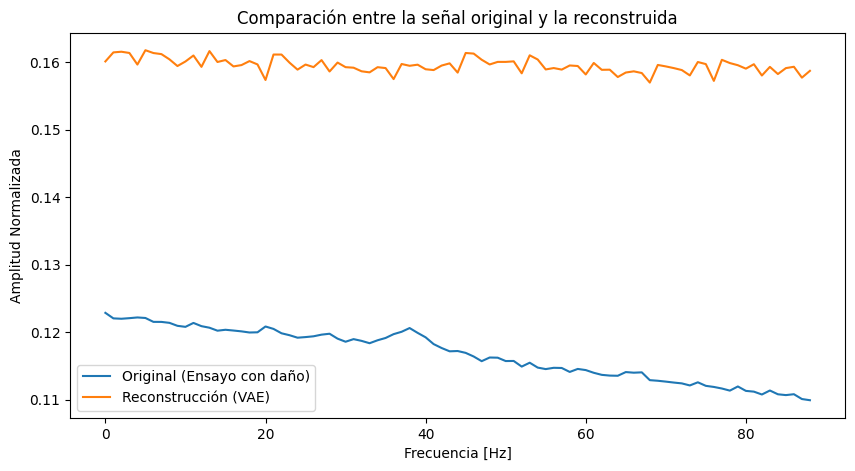

In [21]:
# Evaluación del modelo
def evaluate_model(model, loads_scaled):
    model.eval()
    with torch.no_grad():
        original_signal = loads_scaled[0]
        reconstructed_signal, _, _ = model(original_signal.unsqueeze(0))
        reconstructed_signal = reconstructed_signal.squeeze(0).squeeze(0).detach()
    
    plt.figure(figsize=(10, 5))
    plt.plot(original_signal.squeeze().numpy(), label="Original (Ensayo con daño)")
    plt.plot(reconstructed_signal.numpy(), label="Reconstrucción (VAE)")
    plt.legend()
    plt.title("Comparación entre la señal original y la reconstruida")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Amplitud Normalizada")
    plt.show()

evaluate_model(model, loads_scaled)



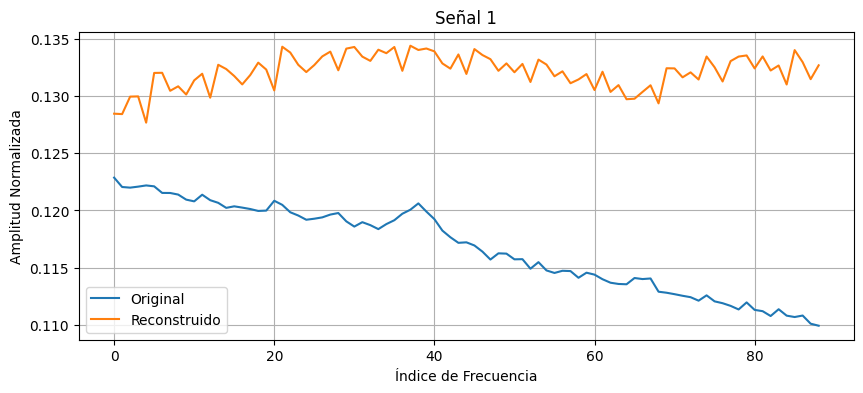

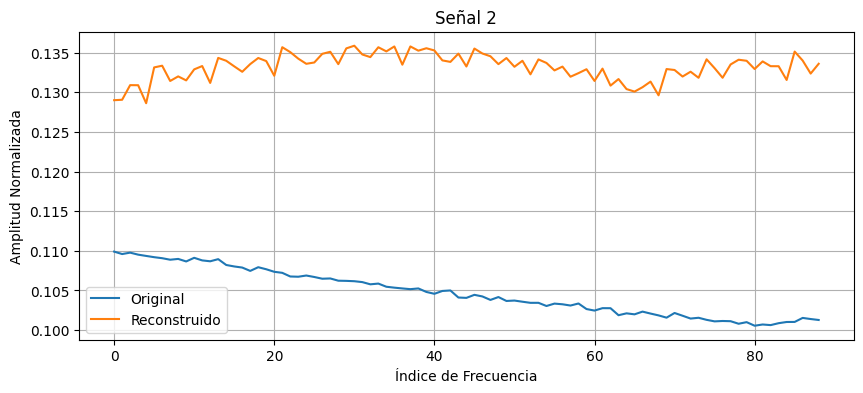

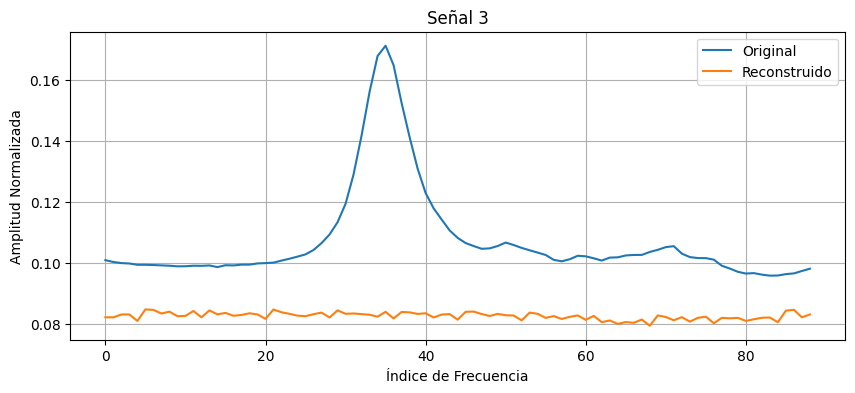

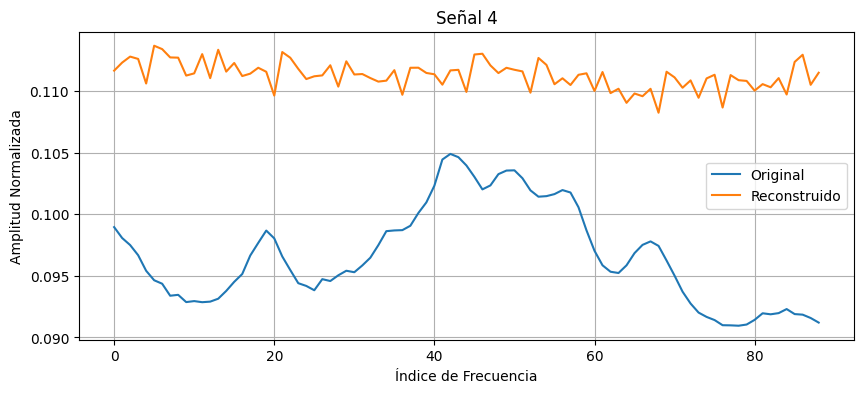

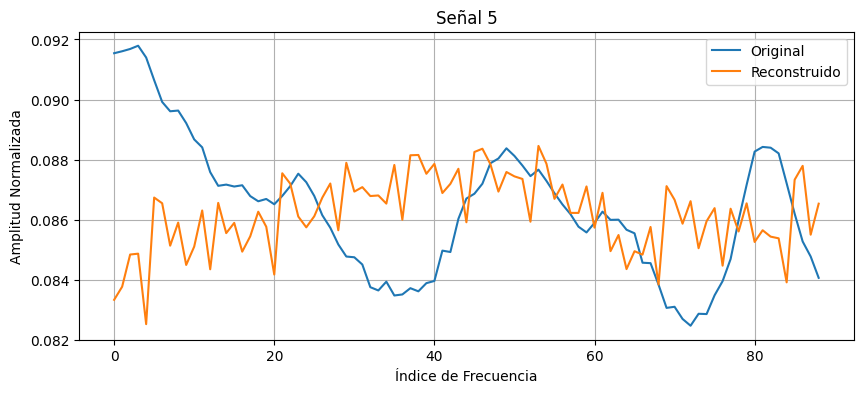

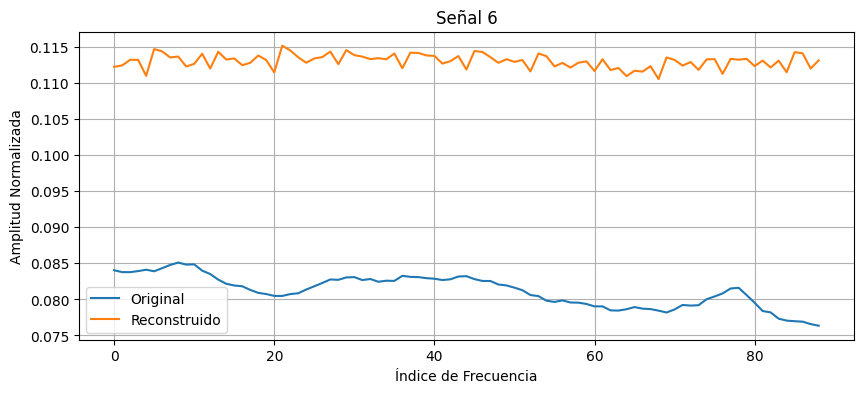

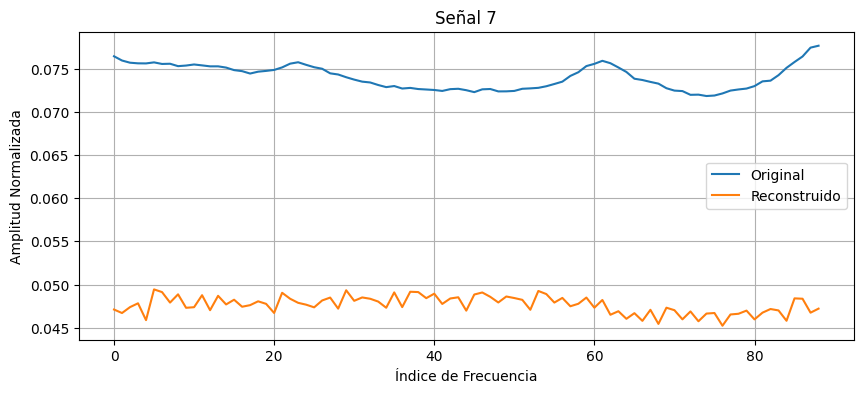

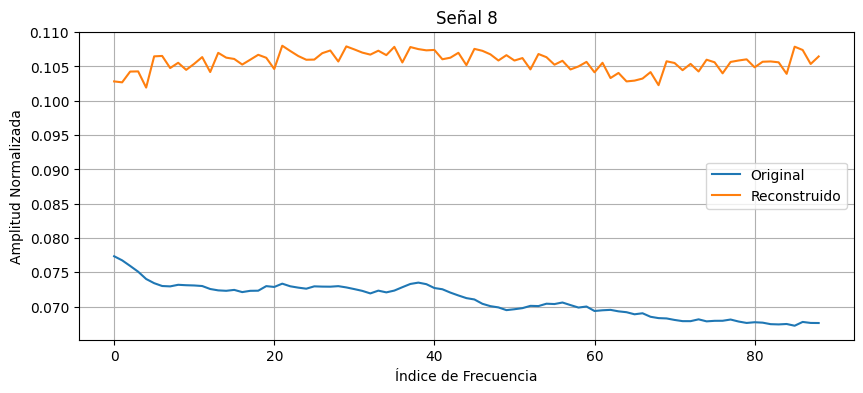

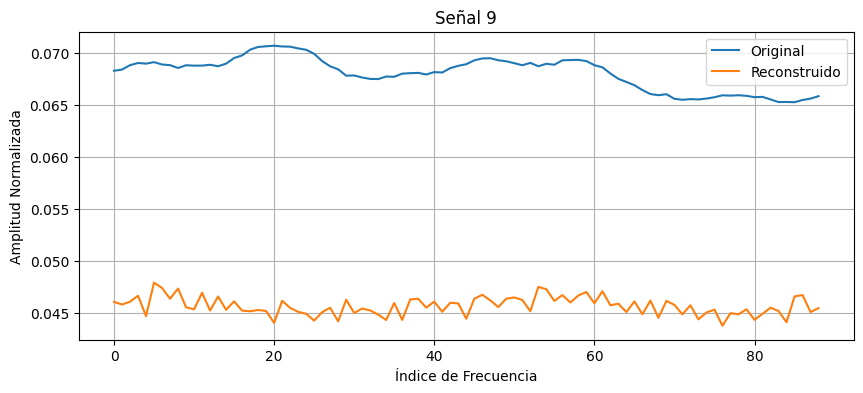

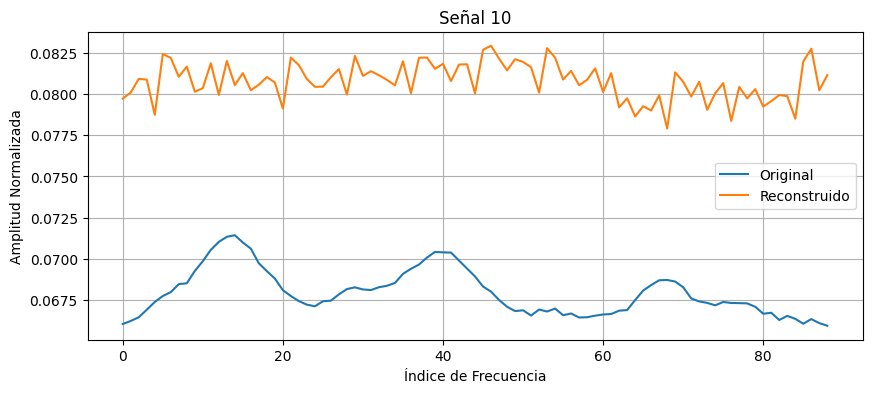

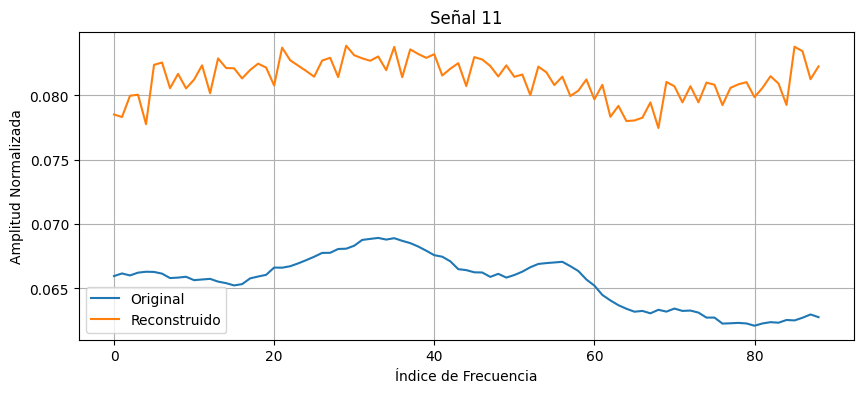

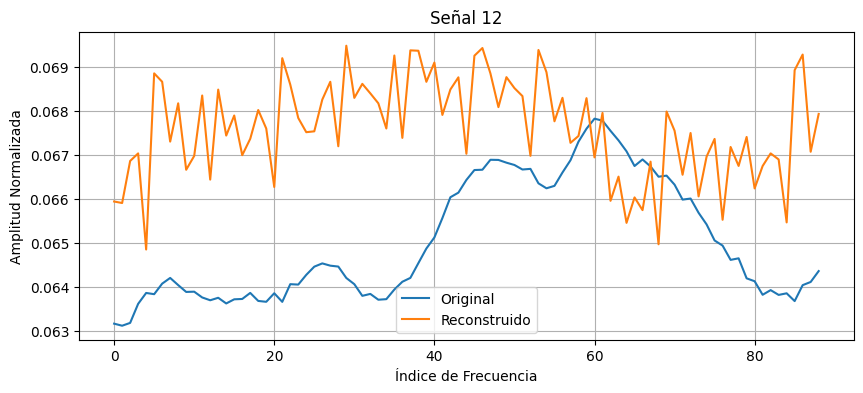

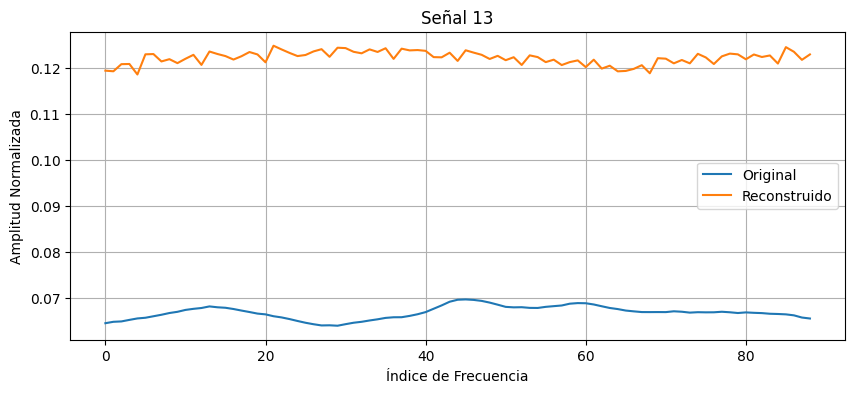

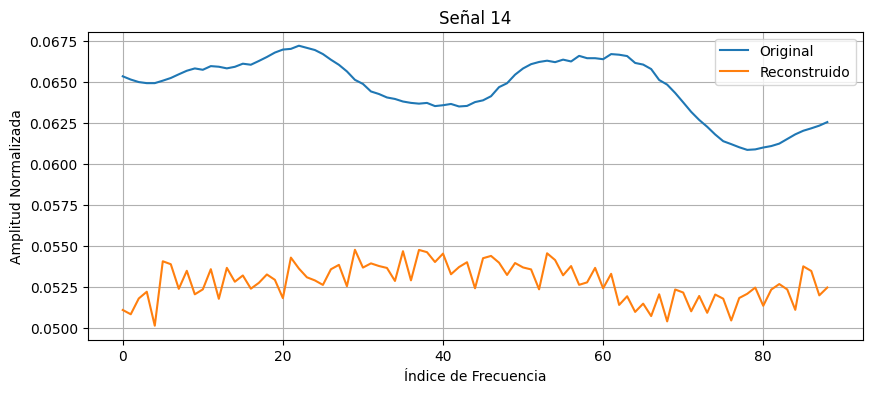

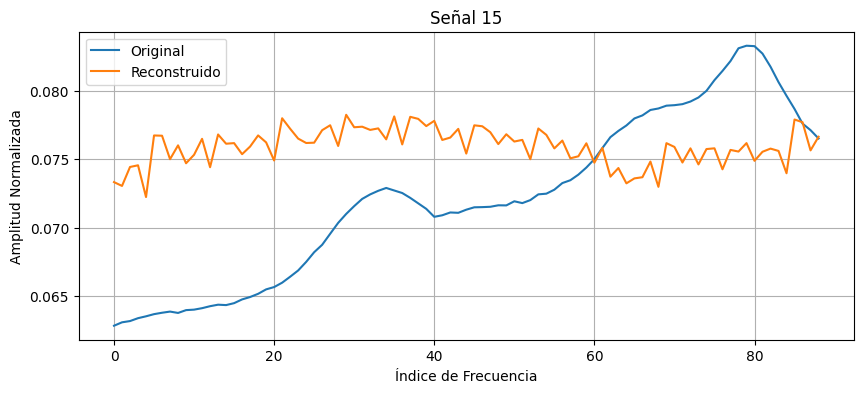

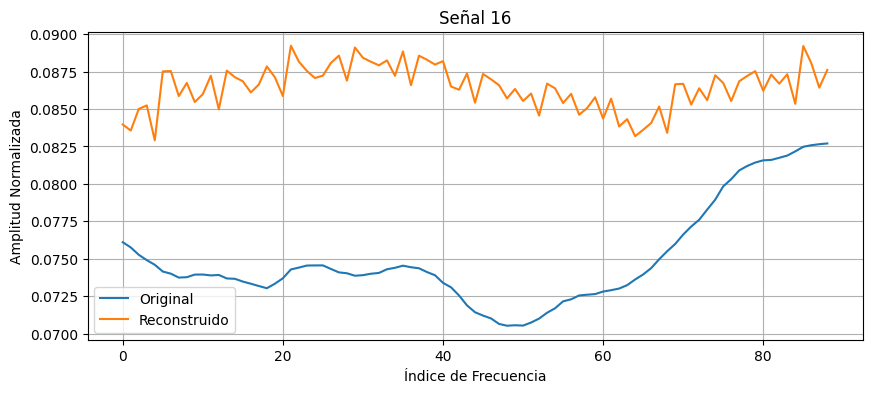

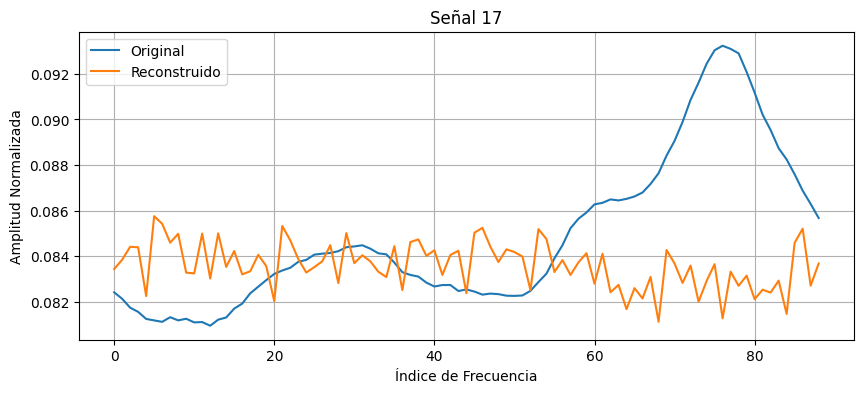

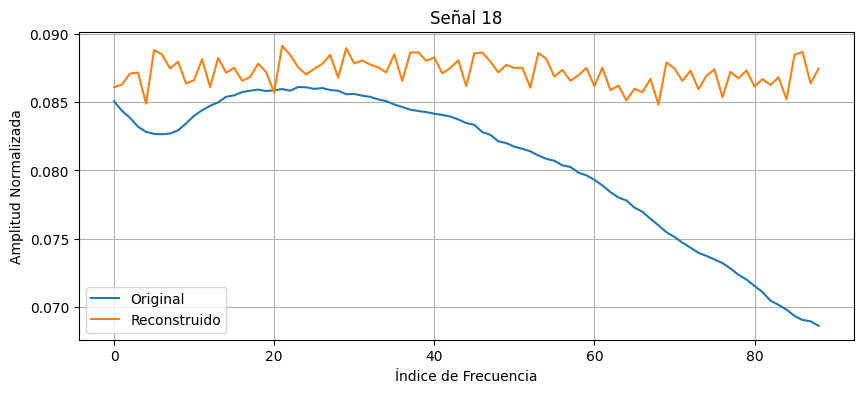

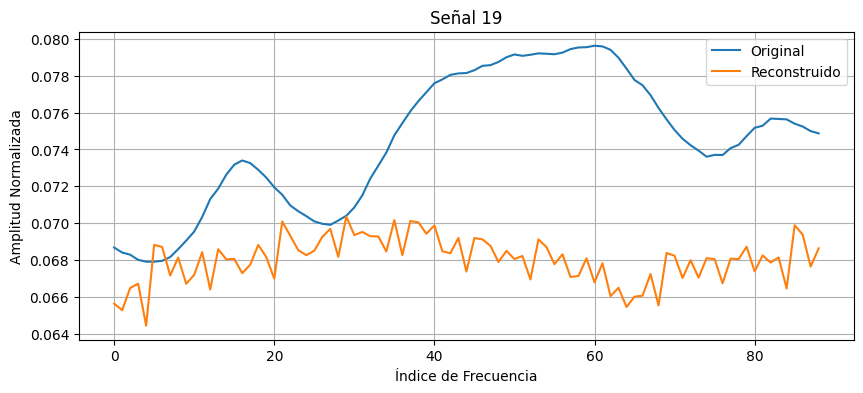

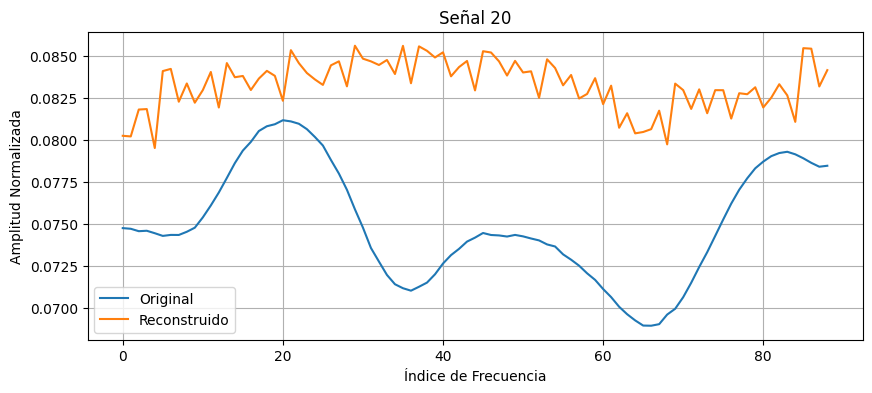

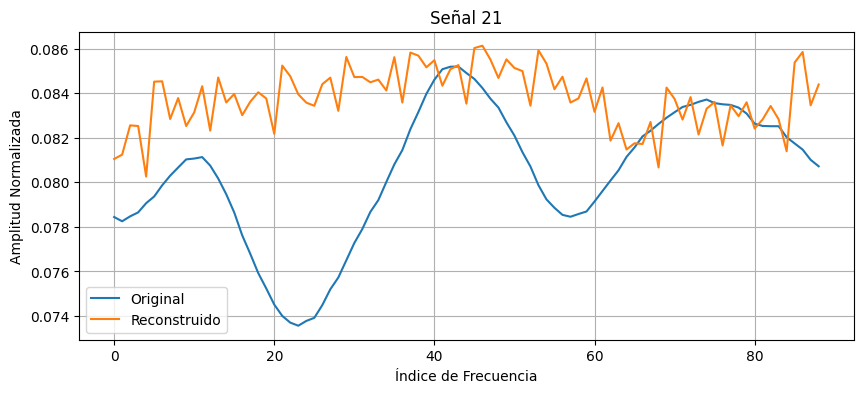

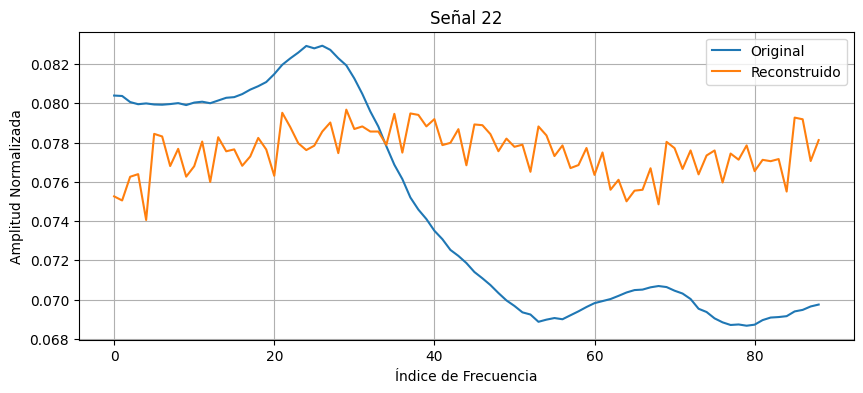

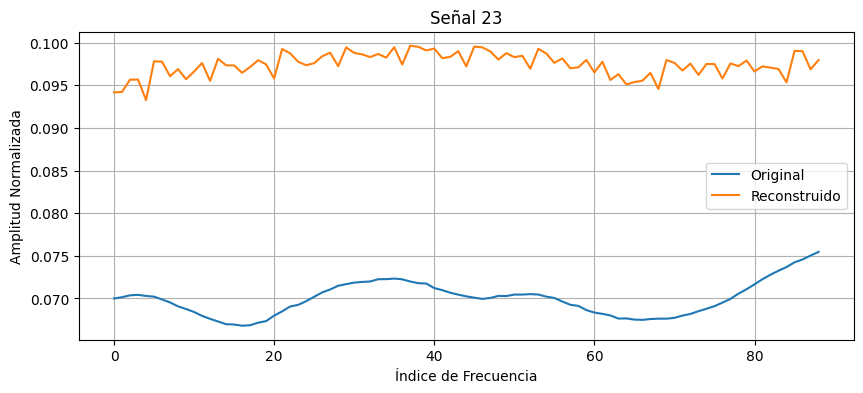

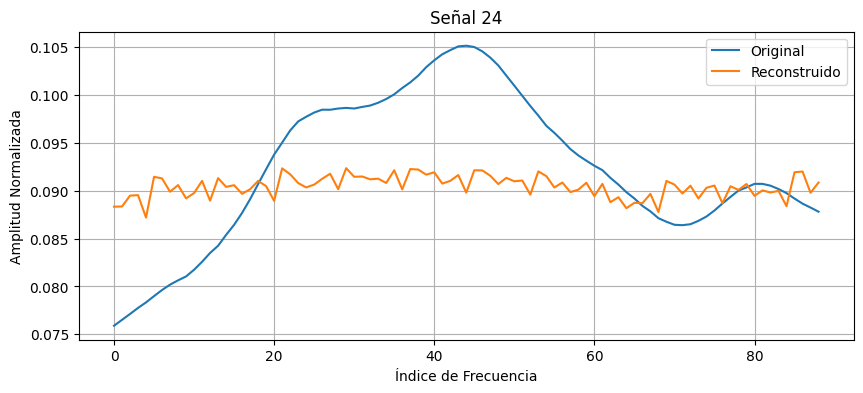

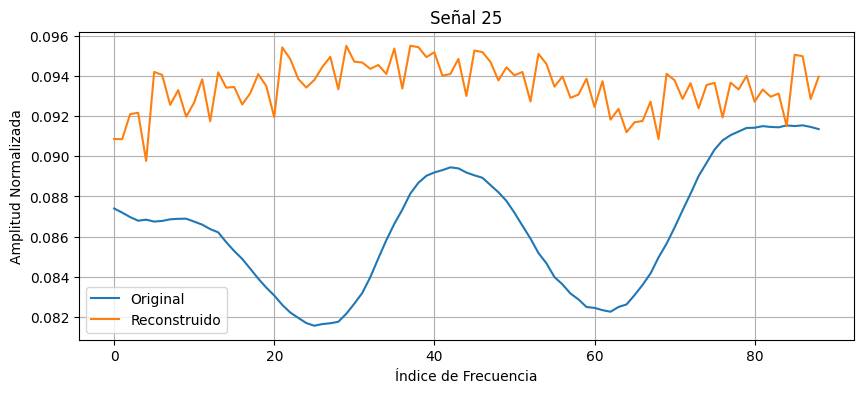

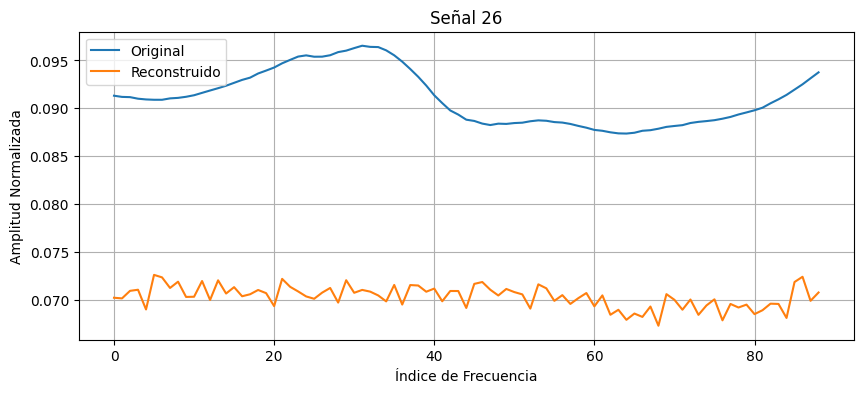

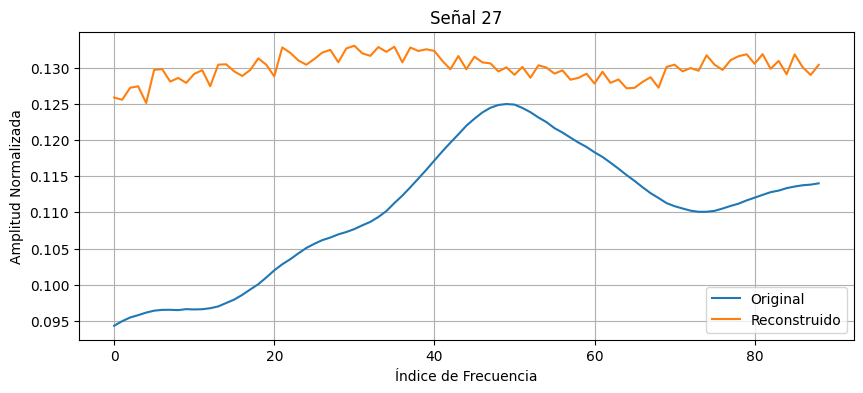

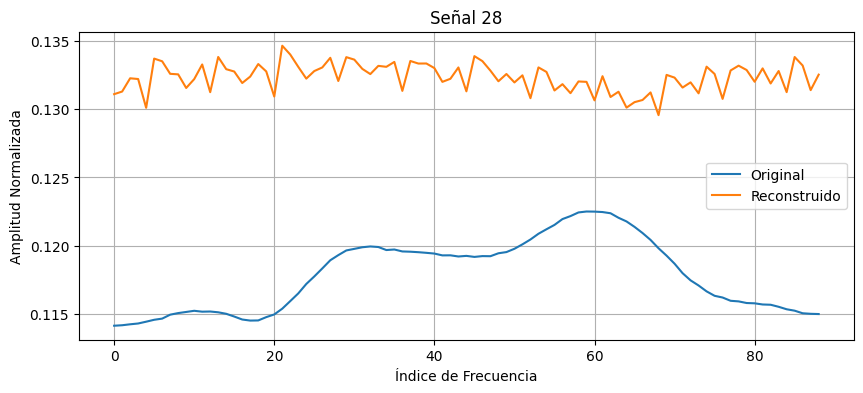

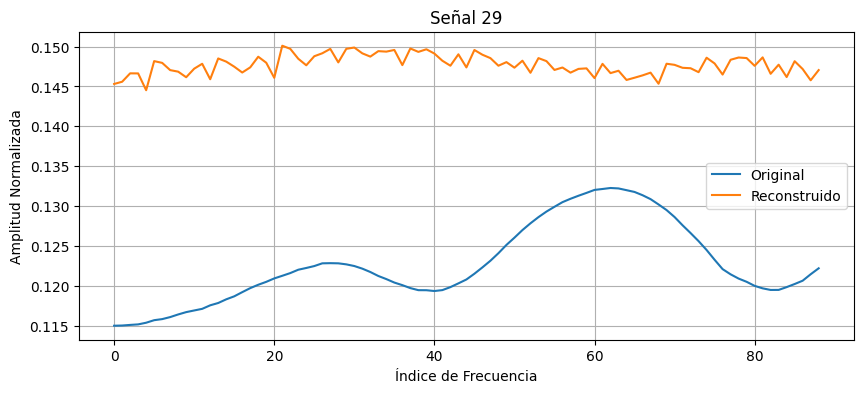

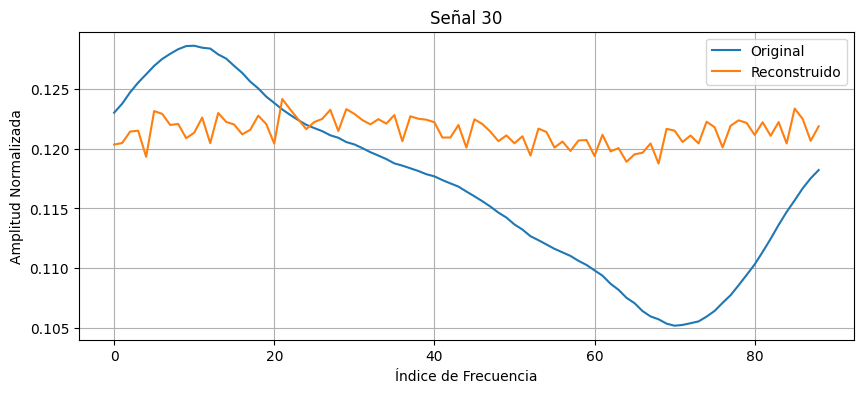

In [13]:
def evaluate_test_signals(model, test_data):
    model.eval()
    with torch.no_grad():
        for i, test_signal in enumerate(test_data[:30]):
            input_tensor = test_signal.unsqueeze(0)  # [1, 1, 89]
            reconstructed = model(input_tensor)[0].squeeze().detach()  # [89]

            plt.figure(figsize=(10, 4))
            plt.plot(test_signal.squeeze().numpy(), label='Original')
            plt.plot(reconstructed.numpy(), label='Reconstruido')
            plt.title(f"Señal {i+1}")
            plt.legend()
            plt.xlabel("Índice de Frecuencia")
            plt.ylabel("Amplitud Normalizada")
            plt.grid(True)
            plt.show()

evaluate_test_signals(model, loads_scaled)